# Case study: Back to the great inflation in 1980s with FED meeting minutes

Compared to news articles, the text of the Fed meeting minutes tends to be more standardized and structured. Instead of conducting sentiment analysis, we will focus on extracting expressions from the text and manually analyzing the subtle attitudes of the Fed.

ChatGPT is used to analyze the topics and patterns present in the text.

- Dataset: sourced from https://www.federalreserve.gov/ in the form of PDFs, and converted to text using OCR technology for analysis. 
- Methodology:
    * 

# 1. Prepare data: loading and preprocessing

In [1]:
import pandas as pd
import os

In [482]:
#Load data
dir = os.getcwd()
data = pd.read_csv(os.path.join(dir,'INPUT/fed_meeting_minutes/fed_minutes_1967-1985.csv'))
#convert string YYYYMMDD to datetime
data["date"] = data.date.apply(lambda x: pd.to_datetime(x, format="%Y%m%d"))
data = data[["date", "text"]]

#concate text by date
df = data.groupby("date").apply(lambda x: x.text.str.cat(sep=" ")).reset_index()
df.columns = ["date", "raw_text"]
#select data from 1979 to 1983
df = df[df.date > "1979-01-01"]
df = df[df.date < "1984-01-01"]
#reset index
df = df.reset_index(drop=True)

In [484]:
#remove the meeting info and the end of the text
df["outlook"] = df.raw_text.apply(lambda x: x.split("foster monetary and financial conditions")[1] if "foster monetary and financial conditions" in x else None)
#remove rows with no outlook
df = df[df.outlook.notnull()]
df["outlook_clean"] = df.outlook.apply(lambda x: x.split("By unanimous vote")[0] if "By unanimous vote" in x else x)

# add "The Federal Open Market Committee seeks to foster monetary and financial conditions" at the beginning of the text
df["outlook_clean"] = "The Federal Open Market Committee seeks to foster monetary and financial conditions" + df.outlook_clean

<AxesSubplot:>

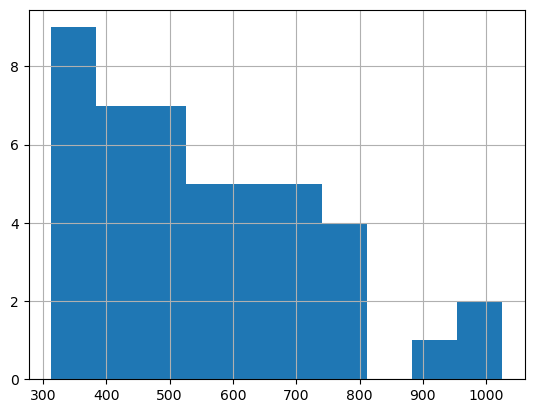

In [485]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.outlook_clean.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [538]:
#select clolumns: date outlook_clean and n_tokens
df = df[["date", "outlook_clean", "n_tokens"]]
#reset index
df = df.reset_index(drop=True)

In [539]:
df

,date,outlook_clean,n_tokens
0,1979-02-06,The Federal Open Market Committee seeks to fos...,343
1,1979-03-20,The Federal Open Market Committee seeks to fos...,485
2,1979-04-17,The Federal Open Market Committee seeks to fos...,483
3,1979-05-22,The Federal Open Market Committee seeks to fos...,538
4,1979-07-11,The Federal Open Market Committee seeks to fos...,669
5,1979-08-14,The Federal Open Market Committee seeks to fos...,616
6,1979-09-18,The Federal Open Market Committee seeks to fos...,711
7,1979-10-06,The Federal Open Market Committee seeks to fos...,475
8,1979-11-20,The Federal Open Market Committee seeks to fos...,503
9,1980-01-09,The Federal Open Market Committee seeks to fos...,433


# 2.Utilizing ChatGPT to analyze the text patterns

In [1]:
import openai

In [ ]:
def pattern_anlysis(prompt_topic,text):

    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
            {"role": "system", "content": "You are a helpful assistant that summarize and analyze text."},
            {"role": "user", "content": prompt_topic + text},
        ]
    )

    return response

## 2.1 Find relevent content in full text by topics

In [ ]:
prompt = """Answer the following questions based on text:
1.list the objectives of the Federal Open Market Committee。
2.quote the most relevent content about the objective of controlling inflation.
3.quote the most relevent content about the objective of ecomonic expansion.
4.quote the most relevent content about the objective of money supply.
5.quote the most relevent content about the objective of the range of federal funds rate.
6.quote the most relevent content about the objective of international transaction.
Text:
"""

In [ ]:
dic = {}

for i in df.index:
    text = df.outlook_clean.values[i]
    response = text_anlysis(text)
    dic[i] = response
    print(i)

In [ ]:
# convert dict to list
list_response = list(dic.values())
#and the list to a new column of df
df_result = df.copy()
df_result["response"] = list_response
df_result["total_tokens"] = df_result.response.apply(lambda x: x["usage"]["total_tokens"])
df_result["answer"] = df_result.response.apply(lambda x: x['choices'][0]['message']['content']) 
#save result df_test
#df_result.to_csv(os.path.join(dir,'OUTPUT/fed_minutes_new_response_1979_1983.csv'), index=False)

In [ ]:
# post processing for GPT response

#remove /n in the text
df_result["answer"] = df_result.answer.apply(lambda x: x.replace("\n", " ") if x is not None else None)
# split answer text to 6 new columns
df_result["answer1"] = df_result.answer.apply(lambda x: x.split("1.")[1].split("2.")[0] if "1." in x else None)
df_result["answer2"] = df_result.answer.apply(lambda x: x.split("2.")[1].split("3.")[0] if "2." in x else None)
df_result["answer3"] = df_result.answer.apply(lambda x: x.split("3.")[1].split("4.")[0] if "3." in x else None)
df_result["answer4"] = df_result.answer.apply(lambda x: x.split("4.")[1].split("5.")[0] if "4." in x else None)
df_result["answer5"] = df_result.answer.apply(lambda x: x.split("5.")[1].split("6.")[0] if "5." in x else None)
df_result["answer6"] = df_result.answer.apply(lambda x: x.split("6.")[1].split("Text:")[0] if "6." in x else None)

## 2.2 Find text patterns for each topic

In [ ]:
def pattern_anlysis(prompt_topic,text):

    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
            {"role": "system", "content": "You are a helpful assistant that summarize and analyze text."},
            {"role": "user", "content": prompt_topic + text},
        ]
    )

    return response

In [ ]:
prompt_inflation = """Please identify the most frequently used phrases or expressions related to inflation in the FED meeting minutes. Here is the extracted text containing information about inflation from several meeting minutes, separated by dashes (-):
"""
inflation_text = df_result.answer2.str.cat(sep='-')
response = pattern_anlysis(prompt_inflation,inflation_text)
print(response['choices'][0]['message']['content'])


The most frequently used phrases or expressions related to inflation in the FED meeting minutes include:

- "The Federal Open Market Committee seeks to foster monetary and financial conditions that will resist inflationary pressures"
- "The Federal Open Market Committee seeks to foster monetary and financial conditions that will help to reduce inflation"
- "The Federal Open Market Committee seeks to foster monetary and financial conditions that will help to reduce inflation further"

These phrases indicate that controlling and reducing inflation is a key objective for the committee. They also emphasize the importance of fostering monetary and financial conditions that resist inflationary pressures while encouraging economic expansion and sustainable international transactions.


In [ ]:
prompt_econ = """Please identify the most frequently used phrases or expressions related to economic growth in the FED meeting minutes. Here is the extracted text containing information about ecomonic growth from several meeting minutes, separated by dashes (-):
"""
#concatenate all answer3 to text
econ_growth_text = df_result.answer3.str.cat(sep='-')
response = pattern_anlysis(prompt_econ, econ_growth_text)
print(response['choices'][0]['message']['content'])

The most frequently used phrases or expressions related to inflation in the FED meeting minutes are "encouraging moderate economic expansion", "encourage economic recovery", "promote sustained economic growth" and "promote a resumption of growth in output on a sustainable basis". These expressions are mentioned multiple times throughout the extracted text from different meeting minutes. Additionally, there is a mention of setting tentative ranges in furtherance of these objectives, which is indirectly related to inflation.


In [ ]:
prompt_money = """Please analyze the following extracted text related to money supply from several FED meeting minutes and provide categories for the different FED's objectives about money supply. The text is separated by dashes (-) and is as follows:
"""
#concatenate all answer4 to text
money_text = df_csv.answer4.str.cat(sep='-')
response = pattern_anlysis(prompt_money, money_text)
print(response['choices'][0]['message']['content'])

Based on the extracted text related to money supply from several FED meeting minutes, we can identify the following categories for FED's objectives about money supply:

1. Growth of M-1, M-2, and M-3 from a specific quarter of one year to the same quarter of the next year within specific ranges (e.g., 1-1/2 to 4-1/2 percent, 5 to 8 percent, and 6 to 9 percent).
2. Maintaining moderate growth in money supply.
3. Maintaining expansion in bank reserves needed for an orderly and sustained flow of money and credit.
4. Monitoring the behavior of the broader monetary aggregates, such as M1 and total domestic nonfinancial debt.
5. Establishing growth ranges for monetary and credit aggregates for a specific year in furtherance of specific objectives (e.g., growth ranges of 2-1/2 to 5-1/2 percent, 6 to 9 percent, and 6-1/2 to 9-1/2 percent for M1, M2, and M3 from the fourth quarter of 1981 to the fourth quarter of 1982).
6. Acknowledging the relationships between growth ranges for monetary and c

# 3. Extrct expression used in the meeting minutes for each topic

This step can be done by python or excel.

# 4. TEST: A deep dive into individual articles using ChatGPT

The sentiment analysis was not effective for analyzing the Fed meeting minutes in 1980s, as the language used in the documents is highly structured and standardized. Instead, we will focus on extracting expressions from the text and manually analyzing the subtle attitudes of the Fed.

The results are shown below for references.

In [ ]:
import openai

def text_anlysis(text):

    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that summarize and analyze text."},
            {"role": "user", "content": prompt + text},
        ]
    )

    return response

In [ ]:
prompt = """Based on the provided text, complete the following tasks:

1.Identify the objective of inflation control and categorize it into one of these three options: maintain the current state, mildly reduce, or strongly reduce.
2.Identify the objective of economic expansion and classify it into one of these three options: maintain the current state, mildly promote, or strongly promote.
3.Identify the objective of money supply and categorize it into one of these five options: maintain the current state, mildly increase, strongly increase, mildly decrease, or strongly decrease.
4.Identify the objective the federal funds rate and classify it into one of these three options: maintain the current state, reduce, or increase.

Text:
"""

In [ ]:
# test response
text = df.outlook_clean.values[-1]
response = text_anlysis(text)
print(response['choices'][0]['message']['content'])

In [ ]:
prompt = """Answer the following questions based on text:
1.list the objectives of the Federal Open Market Committee。
2.quote the most relevent content about the objective of controlling inflation.
3.quote the most relevent content about the objective of ecomonic expansion.
4.quote the most relevent content about the objective of money supply.
5.quote the most relevent content about the objective of the range of federal funds rate.
6.quote the most relevent content about the objective of international transaction.
Text:
"""

In [ ]:
# test response
text = df.outlook_clean.values[2]
response = text_anlysis(text)
print(response['choices'][0]['message']['content'])

1. The objectives of the Federal Open Market Committee are: to resist inflationary pressures, encourage moderate economic expansion, contribute to a sustainable pattern of international transactions, achieve bank reserve and money market conditions consistent with the longer-run ranges for monetary aggregates, and maintain the federal funds rate within a certain range.
2. "The Federal Open Market Committee seeks to foster monetary and financial conditions that will resist inflationary pressures."
3. "encouraging moderate economic expansion"
4. "growth of M-1, M-2, and M-3 from the fourth quarter of 1978 to the fourth quarter of 1979 within ranges of 1-1/2 to 4-1/2 percent, 5 to 8 percent, and 6 to 9 percent, respectively"
5. "maintaining the weekly average federal funds rate within the range of 9-3/4 to 10-1/2 percent"
6. "contributing to a sustainable pattern of international transactions"
